In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 5
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])

['90+72      ', '63+82      ', '5+204      ', '34838+2695 ', '5171+412   '] ['162   ', '145   ', '209   ', '37533 ', '5583  ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]
train_y = y[:20000]
test_x = x[20000:]
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 11, 12)
(18000, 6, 12)
Validation Data:
(2000, 11, 12)
(2000, 6, 12)
Testing Data:
(60000, 11, 12)
(60000, 6, 12)


In [11]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False False
    True]
  [False False False False  True False False False False False False
   False]
  [False False False False False False False False False False  True
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False False False False False False
    True]
  [False False  True False False False False False False False False
   False]
  [False False False False False False  True False False False False
   False]
  [ True False False False False False False False False False False
   False]
  [ True False False False False False False False False False False
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False False False False  True False False False False
   False]
  [False False False False False  True Fal

# Build Model

In [12]:
print('Build model...')
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
import matplotlib.pyplot as plt
training = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 12s 649us/step - loss: 1.8896 - acc: 0.3372 - val_loss: 1.7533 - val_acc: 0.3675
Epoch 2/200
18000/18000 [==============================] - 7s 408us/step - loss: 1.7371 - acc: 0.3707 - val_loss: 1.7461 - val_acc: 0.3648
Epoch 3/200
18000/18000 [==============================] - 7s 401us/step - loss: 1.7121 - acc: 0.3792 - val_loss: 1.7020 - val_acc: 0.3820
Epoch 4/200
18000/18000 [==============================] - 8s 424us/step - loss: 1.6448 - acc: 0.4052 - val_loss: 1.6071 - val_acc: 0.4118
Epoch 5/200
18000/18000 [==============================] - 7s 413us/step - loss: 1.5615 - acc: 0.4237 - val_loss: 1.5491 - val_acc: 0.4200
Epoch 6/200
18000/18000 [==============================] - 7s 389us/step - loss: 1.5213 - acc: 0.4324 - val_loss: 1.5107 - val_acc: 0.4322
Epoch 7/200
18000/18000 [==============================] - 7s 410us/

18000/18000 [==============================] - 5s 297us/step - loss: 0.6416 - acc: 0.7707 - val_loss: 0.9347 - val_acc: 0.6636
Epoch 58/200
18000/18000 [==============================] - 5s 288us/step - loss: 0.6380 - acc: 0.7725 - val_loss: 0.9321 - val_acc: 0.6622
Epoch 59/200
18000/18000 [==============================] - 5s 298us/step - loss: 0.6220 - acc: 0.7790 - val_loss: 0.9396 - val_acc: 0.6663
Epoch 60/200
18000/18000 [==============================] - 4s 218us/step - loss: 0.6133 - acc: 0.7828 - val_loss: 0.9351 - val_acc: 0.6668
Epoch 61/200
18000/18000 [==============================] - 4s 215us/step - loss: 0.6062 - acc: 0.7862 - val_loss: 0.9280 - val_acc: 0.6682
Epoch 62/200
18000/18000 [==============================] - 4s 222us/step - loss: 0.6004 - acc: 0.7882 - val_loss: 0.9414 - val_acc: 0.6652
Epoch 63/200
18000/18000 [==============================] - 4s 227us/step - loss: 0.5886 - acc: 0.7921 - val_loss: 0.9565 - val_acc: 0.6650
Epoch 64/200
18000/18000 [=======

18000/18000 [==============================] - 4s 233us/step - loss: 0.2490 - acc: 0.9245 - val_loss: 1.3445 - val_acc: 0.6663
Epoch 116/200
18000/18000 [==============================] - 5s 284us/step - loss: 0.2395 - acc: 0.9281 - val_loss: 1.3289 - val_acc: 0.6670
Epoch 117/200
18000/18000 [==============================] - 4s 216us/step - loss: 0.2314 - acc: 0.9315 - val_loss: 1.3508 - val_acc: 0.6663
Epoch 118/200
18000/18000 [==============================] - 4s 224us/step - loss: 0.2212 - acc: 0.9365 - val_loss: 1.3746 - val_acc: 0.6661
Epoch 119/200
18000/18000 [==============================] - 4s 226us/step - loss: 0.2233 - acc: 0.9349 - val_loss: 1.3857 - val_acc: 0.6617
Epoch 120/200
18000/18000 [==============================] - 4s 210us/step - loss: 0.2243 - acc: 0.9347 - val_loss: 1.3919 - val_acc: 0.6634
Epoch 121/200
18000/18000 [==============================] - 4s 246us/step - loss: 0.2112 - acc: 0.9398 - val_loss: 1.4113 - val_acc: 0.6652
Epoch 122/200
18000/18000 [

18000/18000 [==============================] - 4s 200us/step - loss: 0.2489 - acc: 0.9185 - val_loss: 2.0581 - val_acc: 0.6545
Epoch 174/200
18000/18000 [==============================] - 4s 200us/step - loss: 0.1837 - acc: 0.9399 - val_loss: 1.9727 - val_acc: 0.6593
Epoch 175/200
18000/18000 [==============================] - 4s 200us/step - loss: 0.0827 - acc: 0.9816 - val_loss: 1.9642 - val_acc: 0.6631
Epoch 176/200
18000/18000 [==============================] - 4s 202us/step - loss: 0.0475 - acc: 0.9963 - val_loss: 1.9936 - val_acc: 0.6613
Epoch 177/200
18000/18000 [==============================] - 4s 204us/step - loss: 0.0373 - acc: 0.9987 - val_loss: 2.0091 - val_acc: 0.6593
Epoch 178/200
18000/18000 [==============================] - 4s 195us/step - loss: 0.0334 - acc: 0.9991 - val_loss: 2.0289 - val_acc: 0.6612
Epoch 179/200
18000/18000 [==============================] - 3s 183us/step - loss: 0.0311 - acc: 0.9994 - val_loss: 2.0513 - val_acc: 0.6593
Epoch 180/200
18000/18000 [

Text(0.5,1,'5 digits add')

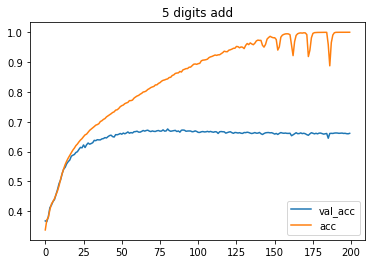

In [14]:
val_acc = training.history['val_acc']
acc = training.history['acc']
plt.figure()
plt.plot(val_acc, label = 'val_acc')
plt.plot(acc, label = 'acc')
plt.legend(loc='lower right')
plt.title('5 digits add')

# Testing

In [15]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
#####################################################
correct_ct = 0
accuracy = 0
for i in range(len(test_x)):
    ind = np.random.randint(0, len(test_x))
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if correct == guess:
        correct_ct = correct_ct + 1
    else: 
        if i < 1000:
            print(i, ' Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
accuracy = correct_ct/len(test_x)
print('accu:', accuracy)

MSG : Prediction
0  Q 53037+5257  T 58294  ☒ 58209 
2  Q 58877+2344  T 61221  ☒ 89012 
3  Q 66+3575     T 3641   ☒ 363   
4  Q 5033+7      T 5040   ☒ 5020  
5  Q 9934+684    T 10618  ☒ 10649 
6  Q 93+2195     T 2288   ☒ 2241  
7  Q 360+801     T 1161   ☒ 1231  
8  Q 5078+6      T 5084   ☒ 5086  
9  Q 723+389     T 1112   ☒ 1241  
10  Q 74469+6508  T 80977  ☒ 81239 
11  Q 27304+95    T 27399  ☒ 27333 
12  Q 891+4838    T 5729   ☒ 5790  
14  Q 96+3540     T 3636   ☒ 3616  
15  Q 7+5385      T 5392   ☒ 5394  
17  Q 3444+734    T 4178   ☒ 4977  
18  Q 9+653       T 662    ☒ 682   
19  Q 286+3064    T 3350   ☒ 3293  
20  Q 9+743       T 752    ☒ 7420  
21  Q 340+57900   T 58240  ☒ 59322 
23  Q 2382+593    T 2975   ☒ 3090  
24  Q 512+89      T 601    ☒ 698   
25  Q 225+50493   T 50718  ☒ 50580 
26  Q 6729+64139  T 70868  ☒ 71179 
27  Q 284+419     T 703    ☒ 622   
28  Q 65648+56489 T 122137 ☒ 132710
29  Q 97219+0     T 97219  ☒ 9723  
30  Q 6931+51     T 6982   ☒ 6983  
31  Q 12+8399     T 

234  Q 6600+5      T 6605   ☒ 6607  
235  Q 1+20611     T 20612  ☒ 20622 
236  Q 61377+5     T 61382  ☒ 61383 
237  Q 42293+384   T 42677  ☒ 42729 
238  Q 6436+24     T 6460   ☒ 6452  
239  Q 79172+6     T 79178  ☒ 79199 
240  Q 222+1744    T 1966   ☒ 2965  
242  Q 384+847     T 1231   ☒ 1221  
243  Q 1369+286    T 1655   ☒ 1845  
244  Q 138+24      T 162    ☒ 170   
245  Q 2+9463      T 9465   ☒ 9468  
246  Q 92020+55    T 92075  ☒ 92026 
247  Q 3067+530    T 3597   ☒ 3545  
248  Q 1+4302      T 4303   ☒ 4304  
249  Q 2+35120     T 35122  ☒ 35111 
251  Q 9+8528      T 8537   ☒ 8546  
252  Q 53742+33    T 53775  ☒ 53765 
253  Q 175+95732   T 95907  ☒ 96810 
255  Q 6833+311    T 7144   ☒ 7957  
256  Q 9337+30483  T 39820  ☒ 38346 
259  Q 63+2917     T 2980   ☒ 2906  
260  Q 8+325       T 333    ☒ 334   
261  Q 3759+4      T 3763   ☒ 3752  
262  Q 227+39      T 266    ☒ 287   
263  Q 921+55      T 976    ☒ 977   
267  Q 9+41673     T 41682  ☒ 41690 
268  Q 1201+14955  T 16156  ☒ 4865  
2

462  Q 82622+2118  T 84740  ☒ 84516 
463  Q 6589+90     T 6679   ☒ 6828  
464  Q 19+51407    T 51426  ☒ 51495 
465  Q 92199+10116 T 102315 ☒ 106760
466  Q 993+96      T 1089   ☒ 1081  
467  Q 878+281     T 1159   ☒ 1066  
468  Q 6166+5864   T 12030  ☒ 12545 
469  Q 43+4081     T 4124   ☒ 4126  
471  Q 44+347      T 391    ☒ 399   
472  Q 2+70675     T 70677  ☒ 706786
473  Q 2711+9367   T 12078  ☒ 11685 
474  Q 58+99132    T 99190  ☒ 99150 
476  Q 6699+77263  T 83962  ☒ 83412 
477  Q 25+4674     T 4699   ☒ 4687  
478  Q 41+5590     T 5631   ☒ 5623  
479  Q 52+416      T 468    ☒ 457   
480  Q 44+253      T 297    ☒ 288   
481  Q 71+2668     T 2739   ☒ 2715  
482  Q 61579+568   T 62147  ☒ 62155 
484  Q 94+7704     T 7798   ☒ 7888  
485  Q 1231+5606   T 6837   ☒ 6868  
486  Q 74617+33    T 74650  ☒ 74665 
487  Q 14236+98570 T 112806 ☒ 111916
488  Q 8959+5681   T 14640  ☒ 15422 
489  Q 724+729     T 1453   ☒ 1441  
490  Q 955+406     T 1361   ☒ 1392  
491  Q 2555+175    T 2730   ☒ 2810  
4

689  Q 443+89260   T 89703  ☒ 89043 
690  Q 541+886     T 1427   ☒ 1327  
691  Q 71854+240   T 72094  ☒ 72364 
692  Q 8102+936    T 9038   ☒ 995   
693  Q 838+6       T 844    ☒ 846   
694  Q 28606+7658  T 36264  ☒ 35449 
697  Q 1261+22     T 1283   ☒ 1274  
698  Q 187+72450   T 72637  ☒ 72619 
699  Q 9+763       T 772    ☒ 770   
700  Q 19969+1     T 19970  ☒ 19978 
701  Q 963+58522   T 59485  ☒ 56373 
702  Q 340+57900   T 58240  ☒ 59322 
703  Q 0+8438      T 8438   ☒ 8439  
704  Q 51425+0     T 51425  ☒ 51435 
705  Q 9219+800    T 10019  ☒ 10122 
706  Q 6807+9416   T 16223  ☒ 15859 
707  Q 162+749     T 911    ☒ 990   
708  Q 3210+382    T 3592   ☒ 3523  
709  Q 894+514     T 1408   ☒ 1486  
710  Q 712+5       T 717    ☒ 716   
711  Q 1201+1      T 1202   ☒ 1211  
712  Q 10+1862     T 1872   ☒ 1875  
713  Q 49+74       T 123    ☒ 124   
714  Q 83+6965     T 7048   ☒ 7049  
715  Q 7167+15064  T 22231  ☒ 20982 
717  Q 949+86271   T 87220  ☒ 87256 
718  Q 8270+2118   T 10388  ☒ 11674 
7

917  Q 95190+43    T 95233  ☒ 95205 
918  Q 2+45931     T 45933  ☒ 45533 
920  Q 67+49686    T 49753  ☒ 50032 
921  Q 490+340     T 830    ☒ 842   
922  Q 6926+26     T 6952   ☒ 6929  
924  Q 677+612     T 1289   ☒ 1299  
925  Q 2+19963     T 19965  ☒ 99964 
926  Q 9+1220      T 1229   ☒ 1220  
927  Q 9605+2      T 9607   ☒ 9606  
928  Q 25+8404     T 8429   ☒ 8433  
929  Q 2169+3756   T 5925   ☒ 3055  
930  Q 20015+403   T 20418  ☒ 20704 
931  Q 61+2313     T 2374   ☒ 2373  
932  Q 59+2629     T 2688   ☒ 2694  
933  Q 459+12      T 471    ☒ 490   
934  Q 97975+42    T 98017  ☒ 98098 
935  Q 478+270     T 748    ☒ 765   
936  Q 69+6606     T 6675   ☒ 6655  
937  Q 1882+9248   T 11130  ☒ 11679 
938  Q 123+9563    T 9686   ☒ 9677  
940  Q 6+839       T 845    ☒ 846   
941  Q 59235+8341  T 67576  ☒ 62516 
942  Q 1532+13     T 1545   ☒ 1535  
944  Q 71445+130   T 71575  ☒ 71565 
945  Q 1+40768     T 40769  ☒ 40785 
946  Q 60380+173   T 60553  ☒ 61355 
947  Q 7934+609    T 8543   ☒ 8515  
9

accu: 0.10283333333333333